## Introduction

This project aims to help Beta Bank with its issue of customer retention. Customers are leaving little by little, and the company wants to predict whether or not a customer will leave the bank. 

This will be done by:
1) Trying different models types to see which yields more reliable results
2) Tuning hyperparameters of given models to maximize efficiency
3) investigating class imbalance and mitigating its potential effects
4) Comparing F1 scores across different models to meet threshold of 0.59
5) Comparing AUC_ROC metrics to ensure model quality

## Download and Clean Data

In [21]:
#load libraries
import pandas as pd
import numpy as np
import math
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score)
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from sklearn import metrics

In [22]:
#download data and look at table attributes
df = pd.read_csv('/datasets/Churn.csv')
display(df.info())
display(df.head(5))


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


None

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In the data set, changes need to be made in order to make this data compatible with our model. The Surname column is being dropped, because encoding it would produce a large amount of unique values that could impair the model and it is unlikely that the information plays a large role in their banking behavior. It does not seem that there are duplicates, but this must be checked and any duplicates must be dropped. The Tenure column is missing values, and these will be replaced with the median value to mitigate the effects of extreme outliers and allow this data to still be used by the model. All remaining object type data (Gender, Geography) will be encoded to comply with our model using OHE. As there is no inherent order to these features, OHE is sufficient.

In [23]:
#drop 'surname' column
df= df.drop(['Surname'], axis=1)
display(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   CreditScore      10000 non-null  int64  
 3   Geography        10000 non-null  object 
 4   Gender           10000 non-null  object 
 5   Age              10000 non-null  int64  
 6   Tenure           9091 non-null   float64
 7   Balance          10000 non-null  float64
 8   NumOfProducts    10000 non-null  int64  
 9   HasCrCard        10000 non-null  int64  
 10  IsActiveMember   10000 non-null  int64  
 11  EstimatedSalary  10000 non-null  float64
 12  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(2)
memory usage: 1015.8+ KB


None

In [24]:
##check for duplicates and drop any that are found
#make all letters lower case to find sneaky duplicates
def convert_to_lower(df):
    for column in df.columns:
        if df[column].dtype == 'object':
            if df[column].str.contains('[A-Z]').any():
                df[column] = df[column].str.lower()
    return df
df = convert_to_lower(df)

#check for duplicated rows
df_duplicated = df.duplicated().sum()
print(f"There are {df_duplicated} duplicated rows in this data frame. As such, none need to be dropped at this time.")

There are 0 duplicated rows in this data frame. As such, none need to be dropped at this time.


In [25]:
# replace missing Tenure values with median
df['Tenure'].fillna(df['Tenure'].median(), inplace=True)
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   CreditScore      10000 non-null  int64  
 3   Geography        10000 non-null  object 
 4   Gender           10000 non-null  object 
 5   Age              10000 non-null  int64  
 6   Tenure           10000 non-null  float64
 7   Balance          10000 non-null  float64
 8   NumOfProducts    10000 non-null  int64  
 9   HasCrCard        10000 non-null  int64  
 10  IsActiveMember   10000 non-null  int64  
 11  EstimatedSalary  10000 non-null  float64
 12  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(2)
memory usage: 1015.8+ KB
None


In [26]:
#use ohe to encode geography and gender features
df = pd.get_dummies(df, columns=['Geography', 'Gender'], drop_first=True)
print(df.columns)

Index(['RowNumber', 'CustomerId', 'CreditScore', 'Age', 'Tenure', 'Balance',
       'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary',
       'Exited', 'Geography_germany', 'Geography_spain', 'Gender_male'],
      dtype='object')


In [27]:
#define the features and target
features = df.drop(['Exited'], axis=1)
target = df['Exited']

#split the data set using the train_test_split method first time (test and train)
feature_train, feature_temp, target_train, target_temp = train_test_split(features, target, test_size=0.4, random_state=123)

#split training set second time (training and validation)
feature_val, feature_test, target_val, target_test = train_test_split(feature_temp, target_temp, test_size = 0.5, random_state = 123)

print(feature_train.shape)
print(feature_test.shape)
print(feature_val.shape)

(6000, 13)
(2000, 13)
(2000, 13)


## Build Model: Examine the balance of classes. Train the model without taking into account the imbalance. Briefly describe your findings.

## Model 1: Logistic Regression

In [28]:
#create and train model
model= LogisticRegression(random_state = 123)
model_1 = model.fit(feature_train, target_train)
pred_val = model_1.predict(feature_val)
score = f1_score(target_val, pred_val)
print(f'F1 score for the unbalanced model for the validation set is: {score}')
print()
print(model.get_params(deep=True))

F1 score for the unbalanced model for the validation set is: 0.0

{'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': 123, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}


AUC-ROC score for the validation set: 0.5480495097698352


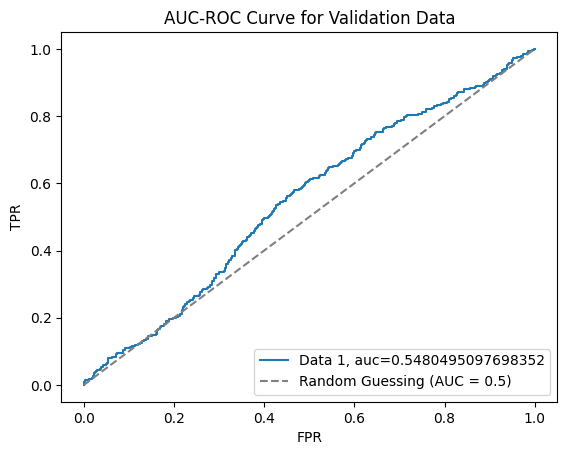

In [29]:
#calculate AUC-ROC for imbalanced model
y_prob_val = model_1.predict_proba(feature_val)[:, 1]
auc_score = roc_auc_score(target_val, y_prob_val)
print(f"AUC-ROC score for the validation set: {auc_score}")

fpr, tpr, _ = metrics.roc_curve(target_val,  y_prob_val)
plt.plot(fpr,tpr,label="Data 1, auc="+str(auc_score))
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Random Guessing (AUC = 0.5)')
plt.legend(loc=4)
plt.title('AUC-ROC Curve for Validation Data' )
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()

A logistic regression has been chosen as a model type for this project. This is because the target is either a 0 (stayed) or a 1 (left) making it a binary categorical target. Because this model has high speed, it should be able to handle the encoded data well.

Without taking into account the class imbalance, even when hyperparameters are optimized, the F1 threshold of 0.59 is not able to be reached. Presumably the heavy class imbalance is causing the F1 score to actually be 0.0.

The model also has a poor AUC-ROC score of 0.55, indicating that it does not predict positive values much better than a random model. 

With this information, it does not make sense to move forward in model testing without reworking the model to compensate for class imbalances.

## Model 2: RandomForestClassifier

In [30]:
#create model and tune hyperparameters using griddearchCV

model = RandomForestClassifier(random_state=123)

#hyperparameter grid
param_grid = {'n_estimators': [1, 100], 'max_depth': [1, 50, None]}
grid_search = GridSearchCV(model, param_grid, cv=5)
grid_search.fit(feature_train, target_train)

#use GridSearch to find optimal parameters
best_model_1 = grid_search.best_estimator_
best_model_1.fit(feature_train, target_train)


pred_val = best_model_1.predict(feature_val)
score = f1_score(target_val, pred_val)
print(f'F1 score for the unbalanced model for the validation set is: {score}')
print()
print(model.get_params(deep=True))

F1 score for the unbalanced model for the validation set is: 0.5560975609756098

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 123, 'verbose': 0, 'warm_start': False}


AUC-ROC score for the validation set: 0.8559431320365887


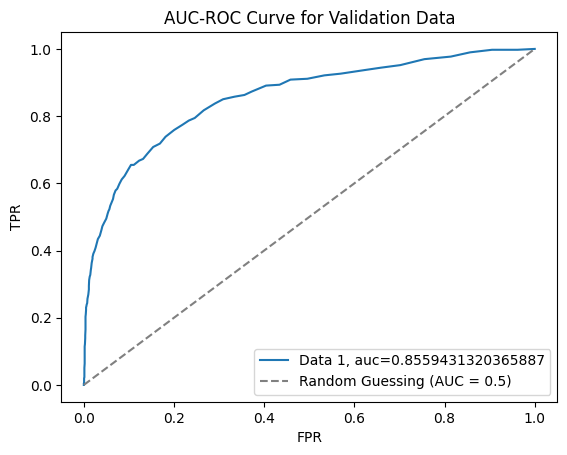

In [31]:
#calculate AUC-ROC for imbalanced model
y_prob_val = best_model_1.predict_proba(feature_val)[:, 1]
auc_score = roc_auc_score(target_val, y_prob_val)
print(f"AUC-ROC score for the validation set: {auc_score}")

fpr, tpr, _ = metrics.roc_curve(target_val,  y_prob_val)
plt.plot(fpr,tpr,label="Data 1, auc="+str(auc_score))
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Random Guessing (AUC = 0.5)')
plt.legend(loc=4)
plt.title('AUC-ROC Curve for Validation Data' )
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()

The RandomForestClassifier model performs better than the logistic regression model even before balancing the classes. The F1 score is higher than that of the logistic regression model at 0.55, however it does not meet project standards. The AUC-ROC score is much higher showing that the model performed better than a random guessing model, yet given all of the information that is given here, class imbalance is still impacting model performance.

## Improve the quality of the model. Make sure you use at least two approaches to fixing class imbalance. Use the training set to pick the best parameters. Train different models on training and validation sets. Find the best one. Briefly describe your findings.

In order to compensate for class imbalance, the unsampling method will be implemented. This will increase instances of the minority class to help the model make predictions more accurately. the class weight parameter will also be set to balanced, giving rare classes higher weight in the model.

Method 1: Unsample Training Set

In [32]:
#rejoin training set to make unsampling possible
train_df = pd.concat([feature_train, target_train], axis=1)

#split data in minority and majority classes
majority_class = train_df[df['Exited'] == train_df['Exited'].value_counts().idxmax()]
minority_class = train_df[df['Exited'] == train_df['Exited'].value_counts().idxmin()]

#increase instances of minority class
minority_class_oversampled = minority_class.sample(n=len(majority_class), replace=True, random_state=123)

#join data together
df_resampled = pd.concat([majority_class, minority_class_oversampled])

#shuffle data
df_resampled = shuffle(df_resampled, random_state=123)

#split the resampled data
feature_train_unsampled = df_resampled.drop(columns='Exited')
target_train_unsampled = df_resampled['Exited']

print(feature_train_unsampled.shape)
print(feature_train.shape)

(9522, 13)
(6000, 13)


/tmp/ipykernel_184/1575973.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  majority_class = train_df[df['Exited'] == train_df['Exited'].value_counts().idxmax()]
/tmp/ipykernel_184/1575973.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  minority_class = train_df[df['Exited'] == train_df['Exited'].value_counts().idxmin()]


Method 2: Balance Class-Weight

## Model 1: Logistic Regression Training on Unsampled Data

In [33]:
#create and train model
model= LogisticRegression(random_state = 123, class_weight = 'balanced')
model_1 = model.fit(feature_train_unsampled, target_train_unsampled)
pred_val = model_1.predict(feature_val)
score = f1_score(target_val, pred_val)
print(f'F1 score for the balanced model for the validation set is: {score}')
print()
print(model.get_params(deep=True))

F1 score for the balanced model for the validation set is: 0.33463541666666663

{'C': 1.0, 'class_weight': 'balanced', 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': 123, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}


AUC-ROC score for the validation set: 0.5486295048390869


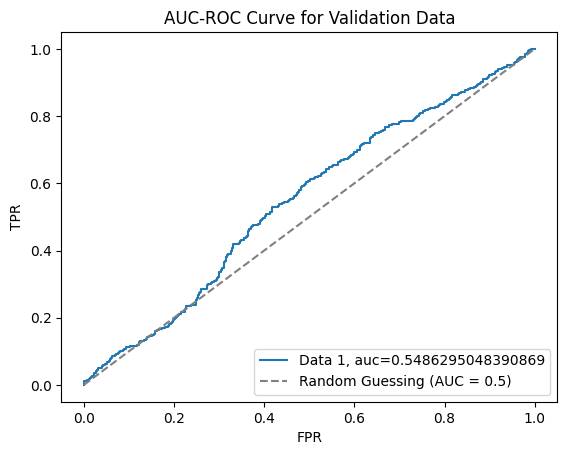

In [34]:
#calculate AUC-ROC for balanced model
y_prob_val = model_1.predict_proba(feature_val)[:, 1]
auc_score = roc_auc_score(target_val, y_prob_val)
print(f"AUC-ROC score for the validation set: {auc_score}")

fpr, tpr, _ = metrics.roc_curve(target_val,  y_prob_val)
plt.plot(fpr,tpr,label="Data 1, auc="+str(auc_score))
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Random Guessing (AUC = 0.5)')
plt.legend(loc=4)
plt.title('AUC-ROC Curve for Validation Data' )
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()

Using these methods we see an increase in the F1 score, however it is still not meeting the necessary threshold of 0.59. The model also has a poor AUC-ROC score of 0.55, indicating that it does not predict positive values much better than a random model.

## Model 2: RandomForestClassifier

In [35]:
#create and train model
model= RandomForestClassifier(random_state = 123, class_weight = 'balanced')
model_2 = model.fit(feature_train_unsampled, target_train_unsampled)
pred_val = model_2.predict(feature_val)
score = f1_score(target_val, pred_val)
print(f'F1 score for the balanced model for the validation set is: {score}')
print()
print(model.get_params(deep=True))

F1 score for the balanced model for the validation set is: 0.5979680696661829

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 123, 'verbose': 0, 'warm_start': False}


AUC-ROC score for the validation set: 0.8609766042315936


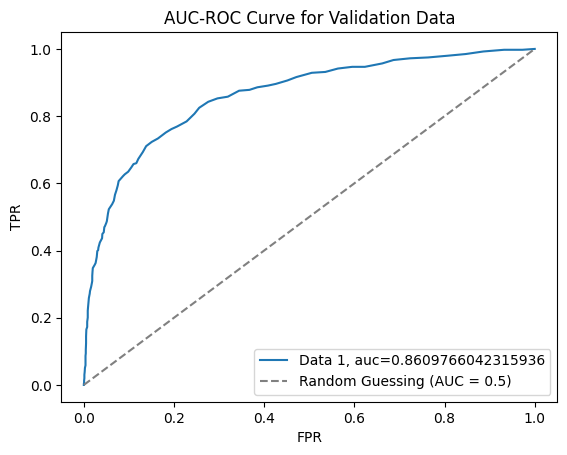

In [36]:
#calculate AUC-ROC for balanced model
y_prob_val = model_2.predict_proba(feature_val)[:, 1]
auc_score = roc_auc_score(target_val, y_prob_val)
print(f"AUC-ROC score for the validation set: {auc_score}")

fpr, tpr, _ = metrics.roc_curve(target_val,  y_prob_val)
plt.plot(fpr,tpr,label="Data 1, auc="+str(auc_score))
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Random Guessing (AUC = 0.5)')
plt.legend(loc=4)
plt.title('AUC-ROC Curve for Validation Data' )
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()

The Random Forest Classifier model does meet the criteria necessary to move forward with the model because the F1 score is higher than 0.59. However hyperparameters will be tuned using the validation set to see if this score can be further increased. The AUC-ROC score is also performing at an acceptable level, showing that the model is better are predicting the correct target than random guessing. 

In [37]:
#tune hyperparameters using gridsearchCV 
model_2 = RandomForestClassifier(random_state = 123, class_weight = 'balanced')

#hyperparameter grid
param_grid = {'n_estimators': [1, 100], 'max_depth': [1, 50, None]}
grid_search = GridSearchCV(model_2, param_grid, cv=5)
grid_search.fit(feature_train_unsampled, target_train_unsampled)

#use GridSearch to find optimal parameters
best_model = grid_search.best_estimator_
best_model.fit(feature_train_unsampled, target_train_unsampled)

#evaluate on the validation set
pred_val = best_model.predict(feature_val)
score = f1_score(target_val, pred_val)
print(f'F1 score for the balanced model for the validation set is: {score}')


F1 score for the balanced model for the validation set is: 0.5979680696661829


AUC-ROC score for the validation set: 0.8609766042315936


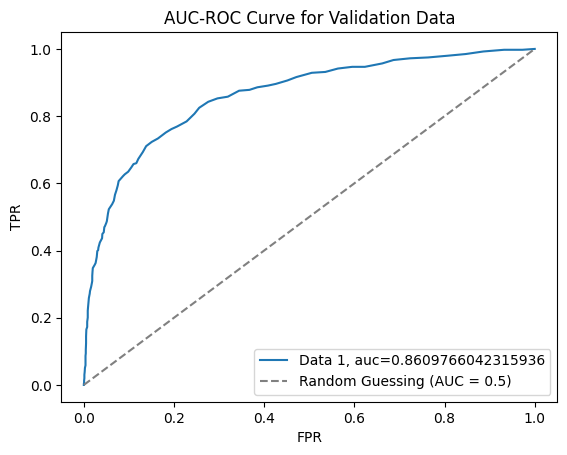

In [38]:
#calculate AUC-ROC for balanced model
y_prob_val = best_model.predict_proba(feature_val)[:, 1]
auc_score = roc_auc_score(target_val, y_prob_val)
print(f"AUC-ROC score for the validation set: {auc_score}")

fpr, tpr, _ = metrics.roc_curve(target_val,  y_prob_val)
plt.plot(fpr,tpr,label="Data 1, auc="+str(auc_score))
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Random Guessing (AUC = 0.5)')
plt.legend(loc=4)
plt.title('AUC-ROC Curve for Validation Data' )
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()

The best model found in this instance is a RandomForestClassifier when the class weight is balanced and trained on unsampled data. The F1 score of 0.598 meets projects criteria and the AUC-ROC score of 0.860 indicates acceptable model performance and that performs better than random guessing models. 

## Perform the final testing (test set)

In [39]:
#use model on test data set
test_pred = best_model.predict(feature_test)
score = f1_score(target_test, test_pred)
print(f'F1 score for the balanced model for the validation set is: {score}')

F1 score for the balanced model for the validation set is: 0.6171428571428571


AUC-ROC score for the test set: 0.8565907342613962


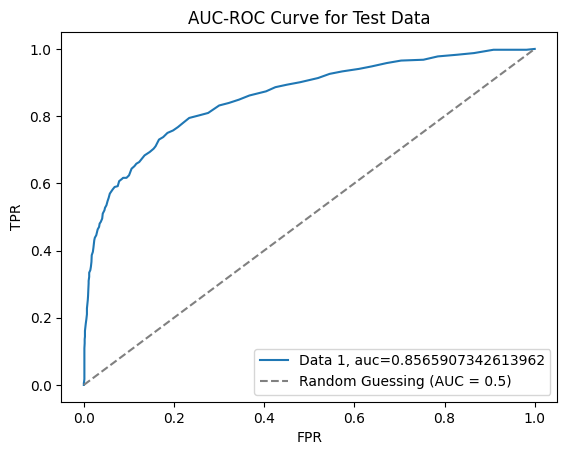

In [40]:
#calculate AUC-ROC for balanced model
y_prob_test = best_model.predict_proba(feature_test)[:, 1]
auc_score = roc_auc_score(target_test, y_prob_test)
print(f"AUC-ROC score for the test set: {auc_score}")

fpr, tpr, _ = metrics.roc_curve(target_test,  y_prob_test)
plt.plot(fpr,tpr,label="Data 1, auc="+str(auc_score))
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Random Guessing (AUC = 0.5)')
plt.legend(loc=4)
plt.title('AUC-ROC Curve for Test Data' )
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()

The RandomForestClassifier Model does meet model requirements when applied to the test data set. This indicates that the model will be able to predict if bank customers are going to leave the Beta Bank in a satisfactory manner.

## Conclusion

Overall, the model that best predicted if customers would leave the Beta Bank was a RandomForestClassifier model that was trained on unsampled data and balanced the class weights. While unsampling data can run the risk for overfitting data, the model met project standards when applied to a test data set. The model could be improved by testing it across further data sets to ensure that it is functioning well in other real world scenarios. 